# Exporatory Data Analysis (EDA) in Rust using Polars and Plotly

## Why use Rust for EDA?

The main characteristic of Rust comparing it to other languages is performance. For big datasets, Rust is the optimal solution. Also DataFrame libraries such as Polars have lazy optimizations thet enable them to be really good at reading lots of data. 
Polars utilizes the Apache Arrow memory model.The goal of Polars is to provide a lightning fast DataFrame library that:  

* Utilizes all available cores on your machine.  
* Optimizes queries to reduce unneeded work/memory allocations.  
* Handles datasets much larger than your available RAM.  
* Has an API that is consistent and predictable.  
* Has a strict schema (data-types should be known before running the query).   
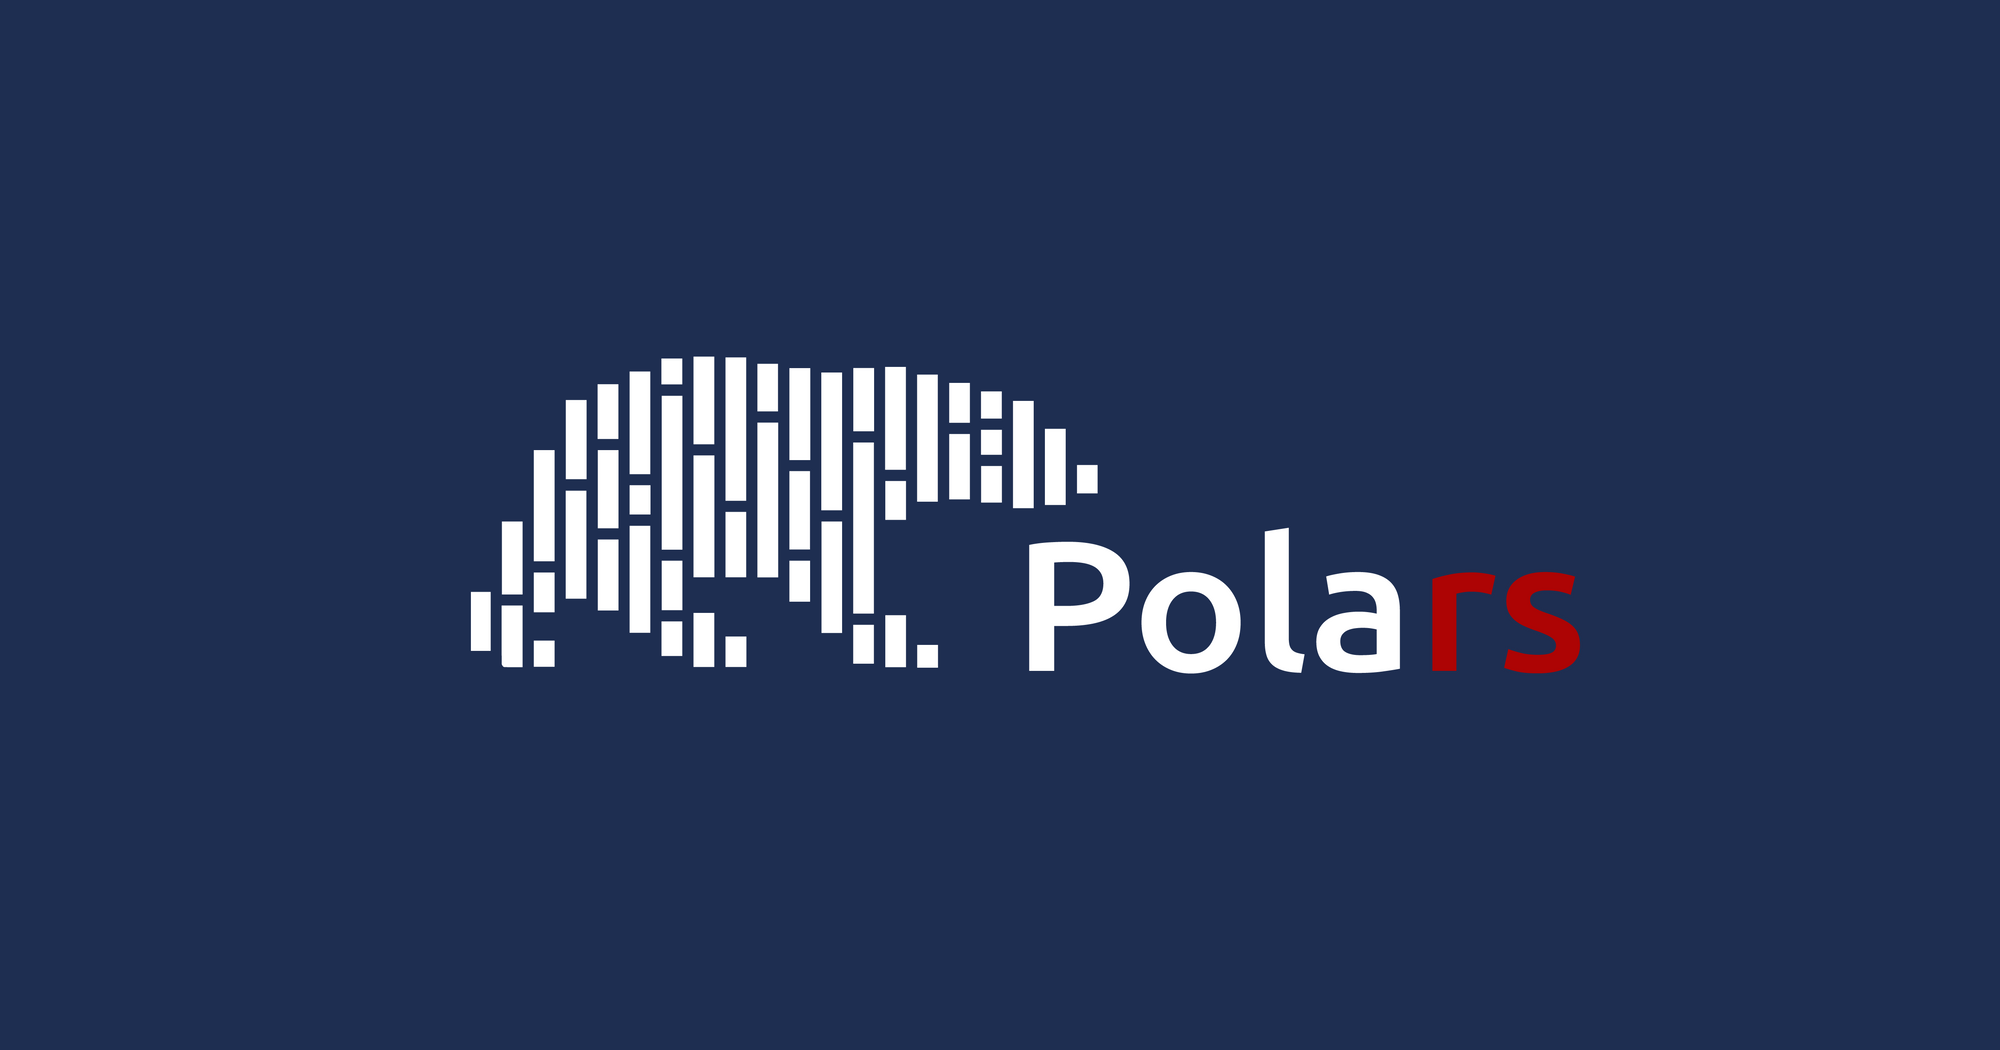


In [2]:
:dep plotly = "0.8.4"
:dep polars = {version = "0.35.4", features = ["describe", "ndarray", "lazy", "object", "dtype-struct", "concat_str", "mode"]}
:dep itertools = "0.12.0"
:dep rand_distr = "0.4.3"
:dep prettytable-rs = "0.10.0"
:dep polars-io = "0.35.4"
:dep polars-lazy = "0.35.4"
:dep polars-core = "0.35.4"
:dep polars-algo = "0.35.4"
:dep polars-ops = "0.35.4"
:dep ndarray-stats = "0.5.1"
:dep ndarray = "0.15"

## Data Exploration  

First we will import the libraries we need, configure the environment variables for polars and use it to read the data, which is stored in a csv file, and gather some information about the dataset.

In [3]:
use polars::prelude::*;
use std::path::Path;
use std::{
    env,
    error::Error,
};
use prettytable::{Table, Row, Cell, row};
use ndarray_stats::CorrelationExt;
use ndarray::{aview2, arr2, Array2};
use plotly::color::NamedColor;
use plotly::common::{ColorScale, ColorScalePalette, Title};
use plotly::contour::Contours;
use plotly::layout::{Axis, Layout, Annotation, BarMode, BoxMode, Margin, LayoutGrid, GridPattern};
use plotly::traces::HeatMap
use plotly::common::{Font, Side, Title, Mode};
use plotly::box_plot::{BoxMean, BoxPoints};
use plotly::common::{ErrorData, ErrorType, Line, Marker, Mode, Orientation,Font, Side, Title, ColorScale, ColorScalePalette};
use plotly::histogram::{Bins, Cumulative, HistFunc, HistNorm};
use plotly::box_plot::{BoxMean, BoxPoints};
use plotly::histogram::{Bins, Cumulative, HistFunc, HistNorm};
use plotly::common::color::{Rgb, Rgba};
use plotly::{Plot, Scatter, Bar, BoxPlot}

pub fn configure_the_environment() {
    env::set_var("POLARS_FMT_TABLE_ROUNDED_CORNERS", "1"); // apply rounded corners to UTF8-styled tables.
    env::set_var("POLARS_FMT_MAX_COLS", "20"); // maximum number of columns shown when formatting DataFrames.
    env::set_var("POLARS_FMT_MAX_ROWS", "10");   // maximum number of rows shown when formatting DataFrames.
    env::set_var("POLARS_FMT_STR_LEN", "50");    // maximum number of characters printed per string value.
}

configure_the_environment();

fn read_data_frame_from_csv(
    csv_file_path: &Path,
) -> DataFrame {
    CsvReader::from_path(csv_file_path)
        .expect("Cannot open file.")
        .has_header(true)
        .finish()
        .unwrap()
}
let df: DataFrame = read_data_frame_from_csv(Path::new("data/Housing.csv"));
//print the first 5 rows
println!("{}", df.head(Some(5)));

//print the last 5 rows
println!("{}", df.tail(Some(5)));

shape: (5, 13)
╭─────┬─────┬─────┬────────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┬───────╮
│ pri ┆ are ┆ bed ┆ bathro ┆ stori ┆ mainr ┆ guest ┆ basem ┆ hotwa ┆ airco ┆ parki ┆ prefa ┆ furni │
│ ce  ┆ a   ┆ roo ┆ oms    ┆ es    ┆ oad   ┆ room  ┆ ent   ┆ terhe ┆ nditi ┆ ng    ┆ rea   ┆ shing │
│ --- ┆ --- ┆ ms  ┆ ---    ┆ ---   ┆ ---   ┆ ---   ┆ ---   ┆ ating ┆ oning ┆ ---   ┆ ---   ┆ statu │
│ i64 ┆ i64 ┆ --- ┆ i64    ┆ i64   ┆ str   ┆ str   ┆ str   ┆ ---   ┆ ---   ┆ i64   ┆ str   ┆ s     │
│     ┆     ┆ i64 ┆        ┆       ┆       ┆       ┆       ┆ str   ┆ str   ┆       ┆       ┆ ---   │
│     ┆     ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆ str   │
╞═════╪═════╪═════╪════════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╡
│ 133 ┆ 742 ┆ 4   ┆ 2      ┆ 3     ┆ yes   ┆ no    ┆ no    ┆ no    ┆ yes   ┆ 2     ┆ yes   ┆ furni │
│ 000 ┆ 0   ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆

## Indexing and Slicing

We can select a single column and return it as a series. Like in Pandas, in Polars a column of rows is a Series and a group of series that has an equal numbers of rows is a DataFrame.

In [4]:
{
    let price_col = &df["price"];
    println!("{}", price_col);

}

shape: (545,)
Series: 'price' [i64]
[
	13300000
	12250000
	12250000
	12215000
	11410000
	…
	1820000
	1767150
	1750000
	1750000
	1750000
]


()

Also, we can make new dataframes from existing dataframes by selecting only some of the columns.

Now we want to copy some of the features presented in pandas for EDA. One of them is df.info() which returns the number of rows and columns the name of the rows and their data type. We can achieve this using 3 functions:  
* df.height -> returns the no. of rows  
* df.weight -> returns the no. of columns
* df.schema -> returns the columns names and their type

In [5]:
let selected_df_columns = df.select(&["price", "area", "bedrooms", "bathrooms"]).unwrap();
selected_df_columns

shape: (545, 4)
╭──────────┬──────┬──────────┬───────────╮
│ price    ┆ area ┆ bedrooms ┆ bathrooms │
│ ---      ┆ ---  ┆ ---      ┆ ---       │
│ i64      ┆ i64  ┆ i64      ┆ i64       │
╞══════════╪══════╪══════════╪═══════════╡
│ 13300000 ┆ 7420 ┆ 4        ┆ 2         │
│ 12250000 ┆ 8960 ┆ 4        ┆ 4         │
│ 12250000 ┆ 9960 ┆ 3        ┆ 2         │
│ 12215000 ┆ 7500 ┆ 4        ┆ 2         │
│ 11410000 ┆ 7420 ┆ 4        ┆ 1         │
│ …        ┆ …    ┆ …        ┆ …         │
│ 1820000  ┆ 3000 ┆ 2        ┆ 1         │
│ 1767150  ┆ 2400 ┆ 3        ┆ 1         │
│ 1750000  ┆ 3620 ┆ 2        ┆ 1         │
│ 1750000  ┆ 2910 ┆ 3        ┆ 1         │
│ 1750000  ┆ 3850 ┆ 3        ┆ 1         │
╰──────────┴──────┴──────────┴───────────╯

## Data Exploration and Cleaning

In [6]:
// Print the number of rows and columns
println!("Number of rows: {}", df.height());
println!("Number of columns: {}", df.width());
// print all the columns names and their type
println!("{:?}", df.schema());

Number of rows: 545
Number of columns: 13
Schema:
name: price, data type: Int64
name: area, data type: Int64
name: bedrooms, data type: Int64
name: bathrooms, data type: Int64
name: stories, data type: Int64
name: mainroad, data type: Utf8
name: guestroom, data type: Utf8
name: basement, data type: Utf8
name: hotwaterheating, data type: Utf8
name: airconditioning, data type: Utf8
name: parking, data type: Int64
name: prefarea, data type: Utf8
name: furnishingstatus, data type: Utf8



In [7]:
// we can also print the schema as a table
fn print_schema_as_pretty_table(schema: &Schema) {
    let mut table = Table::new();
    table.add_row(row!["Column Name", "Data Type"]);

    for field in schema.iter_fields() {
        table.add_row(Row::new(vec![
            Cell::new(field.name()),
            Cell::new(&format!("{:?}", field.data_type())),
        ]));
    }

    // Print the table to stdout
    table.printstd();
}

print_schema_as_pretty_table(&df.schema());

+------------------+-----------+
| Column Name      | Data Type |
+------------------+-----------+
| price            | Int64     |
+------------------+-----------+
| area             | Int64     |
+------------------+-----------+
| bedrooms         | Int64     |
+------------------+-----------+
| bathrooms        | Int64     |
+------------------+-----------+
| stories          | Int64     |
+------------------+-----------+
| mainroad         | Utf8      |
+------------------+-----------+
| guestroom        | Utf8      |
+------------------+-----------+
| basement         | Utf8      |
+------------------+-----------+
| hotwaterheating  | Utf8      |
+------------------+-----------+
| airconditioning  | Utf8      |
+------------------+-----------+
| parking          | Int64     |
+------------------+-----------+
| prefarea         | Utf8      |
+------------------+-----------+
| furnishingstatus | Utf8      |
+------------------+-----------+


In [8]:
// see if we have any null values
df.null_count()

shape: (1, 13)
╭─────┬─────┬─────┬────────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┬───────╮
│ pri ┆ are ┆ bed ┆ bathro ┆ stori ┆ mainr ┆ guest ┆ basem ┆ hotwa ┆ airco ┆ parki ┆ prefa ┆ furni │
│ ce  ┆ a   ┆ roo ┆ oms    ┆ es    ┆ oad   ┆ room  ┆ ent   ┆ terhe ┆ nditi ┆ ng    ┆ rea   ┆ shing │
│ --- ┆ --- ┆ ms  ┆ ---    ┆ ---   ┆ ---   ┆ ---   ┆ ---   ┆ ating ┆ oning ┆ ---   ┆ ---   ┆ statu │
│ u32 ┆ u32 ┆ --- ┆ u32    ┆ u32   ┆ u32   ┆ u32   ┆ u32   ┆ ---   ┆ ---   ┆ u32   ┆ u32   ┆ s     │
│     ┆     ┆ u32 ┆        ┆       ┆       ┆       ┆       ┆ u32   ┆ u32   ┆       ┆       ┆ ---   │
│     ┆     ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆ u32   │
╞═════╪═════╪═════╪════════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╡
│ 0   ┆ 0   ┆ 0   ┆ 0      ┆ 0     ┆ 0     ┆ 0     ┆ 0     ┆ 0     ┆ 0     ┆ 0     ┆ 0     ┆ 0     │
╰─────┴─────┴─────┴────────┴───────┴───────┴───────┴───────┴───────┴───────┴

In [9]:
// see if we have any duplicated rows
let duplicated_rows = df.is_duplicated().unwrap();
let duplicates = df.filter(&duplicated_rows).unwrap();
duplicates

shape: (0, 13)
╭─────┬─────┬─────┬────────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┬───────╮
│ pri ┆ are ┆ bed ┆ bathro ┆ stori ┆ mainr ┆ guest ┆ basem ┆ hotwa ┆ airco ┆ parki ┆ prefa ┆ furni │
│ ce  ┆ a   ┆ roo ┆ oms    ┆ es    ┆ oad   ┆ room  ┆ ent   ┆ terhe ┆ nditi ┆ ng    ┆ rea   ┆ shing │
│ --- ┆ --- ┆ ms  ┆ ---    ┆ ---   ┆ ---   ┆ ---   ┆ ---   ┆ ating ┆ oning ┆ ---   ┆ ---   ┆ statu │
│ i64 ┆ i64 ┆ --- ┆ i64    ┆ i64   ┆ str   ┆ str   ┆ str   ┆ ---   ┆ ---   ┆ i64   ┆ str   ┆ s     │
│     ┆     ┆ i64 ┆        ┆       ┆       ┆       ┆       ┆ str   ┆ str   ┆       ┆       ┆ ---   │
│     ┆     ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆ str   │
╞═════╪═════╪═════╪════════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╡
╰─────┴─────┴─────┴────────┴───────┴───────┴───────┴───────┴───────┴───────┴───────┴───────┴───────╯

Similar as in pandas, we have a function called df.describe() that returns the statistics of the Dataframe and respond to the following questions:  
* How many null values does the Dataframe have?  
* What is the mean, standard deviation and interquantiles of the column if it has a floating point or integer data type (otherwise returns Null)?
* What is the min and the max of the column?

In [10]:
println!("{:?}", df.describe(None));

Ok(shape: (9, 14)
╭─────┬─────┬─────┬─────┬─────┬─────┬─────┬────────┬───────┬───────┬───────┬───────┬───────┬───────╮
│ des ┆ pri ┆ are ┆ bed ┆ bat ┆ sto ┆ mai ┆ guestr ┆ basem ┆ hotwa ┆ airco ┆ parki ┆ prefa ┆ furni │
│ cri ┆ ce  ┆ a   ┆ roo ┆ hro ┆ rie ┆ nro ┆ oom    ┆ ent   ┆ terhe ┆ nditi ┆ ng    ┆ rea   ┆ shing │
│ be  ┆ --- ┆ --- ┆ ms  ┆ oms ┆ s   ┆ ad  ┆ ---    ┆ ---   ┆ ating ┆ oning ┆ ---   ┆ ---   ┆ statu │
│ --- ┆ f64 ┆ f64 ┆ --- ┆ --- ┆ --- ┆ --- ┆ str    ┆ str   ┆ ---   ┆ ---   ┆ f64   ┆ str   ┆ s     │
│ str ┆     ┆     ┆ f64 ┆ f64 ┆ f64 ┆ str ┆        ┆       ┆ str   ┆ str   ┆       ┆       ┆ ---   │
│     ┆     ┆     ┆     ┆     ┆     ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆ str   │
╞═════╪═════╪═════╪═════╪═════╪═════╪═════╪════════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╡
│ cou ┆ 545 ┆ 545 ┆ 545 ┆ 545 ┆ 545 ┆ 545 ┆ 545    ┆ 545   ┆ 545   ┆ 545   ┆ 545.0 ┆ 545   ┆ 545   │
│ nt  ┆ .0  ┆ .0  ┆ .0  ┆ .0  ┆ .0  ┆     ┆        ┆       ┆       ┆     

Now we will work a bit with only the number series to do a correlation matrix and some scatter plots. First, we will select all series with a number data type

In [11]:
let string_columns: Vec<String> = df
.get_column_names()
.iter()
.filter_map(|&col_name| {
    let col = df.column(col_name).unwrap();
    if matches!(col.dtype(), &DataType::Utf8) {
        Some(col_name.to_string())
    } else {
        None
    }
})
.collect();

// Initialize the final DataFrame with the non-string columns
let mut num_df = df.clone();
for col_name in &string_columns {
    num_df = num_df.drop(col_name)?;
}
println!("{}", num_df);

shape: (545, 6)
╭──────────┬──────┬──────────┬───────────┬─────────┬─────────╮
│ price    ┆ area ┆ bedrooms ┆ bathrooms ┆ stories ┆ parking │
│ ---      ┆ ---  ┆ ---      ┆ ---       ┆ ---     ┆ ---     │
│ i64      ┆ i64  ┆ i64      ┆ i64       ┆ i64     ┆ i64     │
╞══════════╪══════╪══════════╪═══════════╪═════════╪═════════╡
│ 13300000 ┆ 7420 ┆ 4        ┆ 2         ┆ 3       ┆ 2       │
│ 12250000 ┆ 8960 ┆ 4        ┆ 4         ┆ 4       ┆ 3       │
│ 12250000 ┆ 9960 ┆ 3        ┆ 2         ┆ 2       ┆ 2       │
│ 12215000 ┆ 7500 ┆ 4        ┆ 2         ┆ 2       ┆ 3       │
│ 11410000 ┆ 7420 ┆ 4        ┆ 1         ┆ 2       ┆ 2       │
│ …        ┆ …    ┆ …        ┆ …         ┆ …       ┆ …       │
│ 1820000  ┆ 3000 ┆ 2        ┆ 1         ┆ 1       ┆ 2       │
│ 1767150  ┆ 2400 ┆ 3        ┆ 1         ┆ 1       ┆ 0       │
│ 1750000  ┆ 3620 ┆ 2        ┆ 1         ┆ 1       ┆ 0       │
│ 1750000  ┆ 2910 ┆ 3        ┆ 1         ┆ 1       ┆ 0       │
│ 1750000  ┆ 3850 ┆ 3        ┆ 1       

We will do a statistics describe to make sure that we filtered the dataset.

In [12]:
println!("{:?}", num_df.describe(None));

Ok(shape: (9, 7)
╭────────────┬──────────┬─────────────┬──────────┬───────────┬──────────┬──────────╮
│ describe   ┆ price    ┆ area        ┆ bedrooms ┆ bathrooms ┆ stories  ┆ parking  │
│ ---        ┆ ---      ┆ ---         ┆ ---      ┆ ---       ┆ ---      ┆ ---      │
│ str        ┆ f64      ┆ f64         ┆ f64      ┆ f64       ┆ f64      ┆ f64      │
╞════════════╪══════════╪═════════════╪══════════╪═══════════╪══════════╪══════════╡
│ count      ┆ 545.0    ┆ 545.0       ┆ 545.0    ┆ 545.0     ┆ 545.0    ┆ 545.0    │
│ null_count ┆ 0.0      ┆ 0.0         ┆ 0.0      ┆ 0.0       ┆ 0.0      ┆ 0.0      │
│ mean       ┆ 4.7667e6 ┆ 5150.541284 ┆ 2.965138 ┆ 1.286239  ┆ 1.805505 ┆ 0.693578 │
│ std        ┆ 1.8704e6 ┆ 2170.141023 ┆ 0.738064 ┆ 0.50247   ┆ 0.867492 ┆ 0.861586 │
│ min        ┆ 1.75e6   ┆ 1650.0      ┆ 1.0      ┆ 1.0       ┆ 1.0      ┆ 0.0      │
│ 25%        ┆ 3.43e6   ┆ 3600.0      ┆ 2.0      ┆ 1.0       ┆ 1.0      ┆ 0.0      │
│ 50%        ┆ 4.34e6   ┆ 4600.0      ┆ 3.0     

In [13]:
let column_names: Vec<String> = num_df.get_column_names()
                                        .iter()
                                        .map(|s| s.to_string())
                                        .collect();
let tick_values: Vec<f64> = (0..column_names.len()).map(|x| x as f64).collect();

// println!("{:?}", column_names);
// println!("{:?}", tick_values);

let corr_matrix = num_df
    .to_ndarray::<Float64Type>(IndexOrder::Fortran)
    .unwrap()
    .t()
    .pearson_correlation()
    .unwrap();


let corr_matrix_vec: Vec<Vec<f64>> = corr_matrix
    .axis_iter(ndarray::Axis(0)) // Iterate over the rows (axis 0)
    .map(|row| row.to_vec()) // Convert each row to a Vec<f64>
    .collect(); // Collect rows into a Vec<Vec<f64>>

// println!("{:?}", corr_matrix_vec);
let mut annotations:Vec<Annotation> = Vec::new();
for (i, row) in corr_matrix_vec.iter().enumerate() {
    for (j, &value) in row.iter().enumerate() {
        let annotation = Annotation::new()
            .x(j as f64) 
            .y(i as f64) 
            .text(format!("{:.2}", value)) 
            .show_arrow(false); 
        annotations.push(annotation);
    }
}

//let trace = HeatMap::new_z(corr_matrix_vec);
let trace = plotly::traces::HeatMap::new(column_names.clone(), column_names.clone(), corr_matrix_vec);
let layout: Layout = Layout::new()
    .title(Title::new("Correlation Matrix Housing Data"))
    .x_axis(Axis::new().title(Title::new(""))
        .tick_values(tick_values.clone()) // Set the numerical positions of the ticks
        .tick_text(column_names.clone())) // Set the labels for the ticks
    .y_axis(Axis::new().title(Title::new(""))
        .tick_values(tick_values) // Set the numerical positions of the ticks
        .tick_text(column_names)) // Set the labels for the ticks
    .annotations(annotations);
// println!("{:?}", layout);
let mut plot = Plot::new();
plot.set_layout(layout);
plot.add_trace(trace);
plot.notebook_display();

Now we will do some scatter plots using the numerical data, and labelling it by using categorical data. First we will transform the columns to a vector of vectors

In [14]:
let columns:Vec<Vec<f64>> = num_df.select(&["price", "area", "bedrooms", "bathrooms", "stories", "parking"])
                  .unwrap()
                  .to_ndarray::<Float64Type>(IndexOrder::Fortran)
                  .unwrap()
                  .axis_iter(ndarray::Axis(1))
                  .map(|column| column.to_vec())
                  .collect();
println!("prices: \n{:?} \n{}", columns[0], columns[0].len());

prices: 
[13300000.0, 12250000.0, 12250000.0, 12215000.0, 11410000.0, 10850000.0, 10150000.0, 10150000.0, 9870000.0, 9800000.0, 9800000.0, 9681000.0, 9310000.0, 9240000.0, 9240000.0, 9100000.0, 9100000.0, 8960000.0, 8890000.0, 8855000.0, 8750000.0, 8680000.0, 8645000.0, 8645000.0, 8575000.0, 8540000.0, 8463000.0, 8400000.0, 8400000.0, 8400000.0, 8400000.0, 8400000.0, 8295000.0, 8190000.0, 8120000.0, 8080940.0, 8043000.0, 7980000.0, 7962500.0, 7910000.0, 7875000.0, 7840000.0, 7700000.0, 7700000.0, 7560000.0, 7560000.0, 7525000.0, 7490000.0, 7455000.0, 7420000.0, 7420000.0, 7420000.0, 7350000.0, 7350000.0, 7350000.0, 7350000.0, 7343000.0, 7245000.0, 7210000.0, 7210000.0, 7140000.0, 7070000.0, 7070000.0, 7035000.0, 7000000.0, 6930000.0, 6930000.0, 6895000.0, 6860000.0, 6790000.0, 6790000.0, 6755000.0, 6720000.0, 6685000.0, 6650000.0, 6650000.0, 6650000.0, 6650000.0, 6650000.0, 6650000.0, 6629000.0, 6615000.0, 6615000.0, 6580000.0, 6510000.0, 6510000.0, 6510000.0, 6475000.0, 6475000.0, 644

In [15]:
let column_names: Vec<String> = num_df.get_column_names()
                                        .iter()
                                        .map(|s| s.to_string())
                                        .collect();


let columns:Vec<Vec<f64>> = num_df.select(&["price", "area", "bedrooms", "bathrooms", "stories", "parking"])
                                        .unwrap()
                                        .to_ndarray::<Float64Type>(IndexOrder::Fortran)
                                        .unwrap()
                                        .axis_iter(ndarray::Axis(1))
                                        .map(|column| column.to_vec())
                                        .collect();
// Assuming you have a way to map each column name to its unit
let units = vec!["$", "sq meters", "no.", "no.", "no.", "no."];
// ... the rest of your units corresponding to the columns

let mut plot = Plot::new();
let mut traces: Vec<Box<Scatter<f64, f64>>> = Vec::new();
let mut axis_index = 1;

for i in 0..columns.len() {
    for j in (i + 1)..columns.len() {
        let trace = Scatter::new(columns[i].clone(), columns[j].clone())
            .name(&format!("{}({}) vs {}({})", column_names[i], units[i], column_names[j], units[j]))
            .mode(Mode::Markers)
            .x_axis(&format!("x{}", axis_index))
            .y_axis(&format!("y{}", axis_index));
        traces.push(trace);
        axis_index += 1;
    }
}
//println!("{:?}", traces);
for trace in traces {
    plot.add_trace(trace);
}


let layout = Layout::new()
    .width(1200)
    .height(1500)
    .title(Title::new("Scatter Matrix Housing Data"))
    .grid(
    LayoutGrid::new()
        .rows(5)
        .columns(3)
        .pattern(GridPattern::Independent),
);

plot.set_layout(layout);
plot.notebook_display();

In [16]:
// Now we will do the boxplots 
let mut plot = Plot::new();
let layout = Layout::new()
    .title(Title::new(
        "Box plots of the bathrooms bedrooms stories and parking columns of the Housing Dataset",
    ))
    .y_axis(
        Axis::new()
            .auto_range(true)
            .show_grid(true)
            .zero_line(true)
            .dtick(5.0)
            .grid_color(Rgb::new(255, 255, 255))
            .grid_width(1)
            .zero_line_color(Rgb::new(255, 255, 255))
            .zero_line_width(2),
    )
    .margin(Margin::new().left(40).right(30).bottom(80).top(100))
    .paper_background_color(Rgb::new(243, 243, 243))
    .plot_background_color(Rgb::new(243, 243, 243))
    .show_legend(false);
plot.set_layout(layout);

for index in 2..columns.len() {
    let trace = BoxPlot::new(columns[index].clone())
        .name(column_names[index].clone())
        .box_points(BoxPoints::All)
        .jitter(0.5)
        .whisker_width(0.2)
        .marker(Marker::new().size(6))
        .line(Line::new().width(2.0));
    plot.add_trace(trace);
}
plot.notebook_display();

In [17]:
let mut plot = Plot::new();
let layout = Layout::new()
    .title(Title::new(
        "Box plot of the price column of the Housing Dataset",
    ))
    .margin(Margin::new().left(40).right(30).bottom(80).top(100))
    .paper_background_color(Rgb::new(243, 243, 243))
    .plot_background_color(Rgb::new(243, 243, 243))
    .show_legend(false);
for index in 0..1{
    let trace = BoxPlot::new(columns[0].clone())
    .name(column_names[0].clone())
    .marker(
        Marker::new()
            .color(Rgb::new(8, 81, 156))
            .outlier_color(Rgba::new(219, 64, 82, 0.6))
            .line(
                Line::new()
                    .outlier_color(Rgba::new(219, 64, 82, 1.0))
                    .outlier_width(2),
            ),
    )
    .box_points(BoxPoints::SuspectedOutliers);
    plot.add_trace(trace);
}


plot.set_layout(layout);


plot.notebook_display();

In [18]:
let mut plot = Plot::new();
let layout = Layout::new()
    .title(Title::new(
        "Box plot of the area column of the Housing Dataset",
    ))
    .margin(Margin::new().left(40).right(30).bottom(80).top(100))
    .paper_background_color(Rgb::new(243, 243, 243))
    .plot_background_color(Rgb::new(243, 243, 243))
    .show_legend(false);
for index in 1..2{
    let trace = BoxPlot::new(columns[index].clone())
    .name(column_names[index].clone())
    .marker(
        Marker::new()
            .color(Rgb::new(8, 81, 156))
            .outlier_color(Rgba::new(219, 64, 82, 0.6))
            .line(
                Line::new()
                    .outlier_color(Rgba::new(219, 64, 82, 1.0))
                    .outlier_width(2),
            ),
    )
    .box_points(BoxPoints::SuspectedOutliers);
    plot.add_trace(trace);
}


plot.set_layout(layout);


plot.notebook_display();

 We want to find out what is the relationship between price and area for furnishing status.


In [19]:
fn extract_data(df: &DataFrame, furnishing_status: &str) -> Result<Vec<Vec<f64>>, Box<dyn Error>> {
    let mask = df
        .column("furnishingstatus")?
        .utf8()?
        .into_iter()
        .map(|value| value == Some(furnishing_status))
        .collect::<BooleanChunked>();

    let filtered_df = df.filter(&mask)?;

    // Convert columns to f64 if they are i64
    let price = filtered_df
        .column("price")?
        .cast(&DataType::Float64)?
        .f64()?
        .into_no_null_iter()
        .collect::<Vec<f64>>();

    let area = filtered_df
        .column("area")?
        .cast(&DataType::Float64)?
        .f64()?
        .into_no_null_iter()
        .collect::<Vec<f64>>();

    Ok(vec![price, area])
}

In [20]:
let unfurnished_data = extract_data(&df, "unfurnished")?;
let semi_furnished_data = extract_data(&df, "semi-furnished")?;
let furnished_data = extract_data(&df, "furnished")?;

In [21]:
fn colored_and_styled_scatter_plot(unfurnished_data: Vec<Vec<f64>>, semi_furnished_data: Vec<Vec<f64>>, furnished_data: Vec<Vec<f64>>) {

    let trace1 = Scatter::new(unfurnished_data[0].clone(), unfurnished_data[1].clone())
        .mode(Mode::Markers)
        .name("unfurnished")
        .marker(
            Marker::new()
                .color(Rgb::new(164, 194, 244))
                .size(12)
                .line(Line::new().color(NamedColor::White).width(0.5)),
        );
    let trace2 = Scatter::new(
        semi_furnished_data[0].clone(),
        semi_furnished_data[1].clone(),
    )
    .mode(Mode::Markers)
    .name("semi-furnished")
    .marker(Marker::new().color(Rgb::new(255, 217, 102)).size(12));
    let trace3 = Scatter::new(
        furnished_data[0].clone(),
        furnished_data[1].clone(),
    )
    .mode(Mode::Markers)
    .name("furnsihed")
    .marker(Marker::new().color(Rgb::new(234, 153, 153)).size(12));

    let layout = Layout::new()
        .title(Title::new("Plot of Price vs Area for Furnishing Status"))
        .x_axis(
            Axis::new()
                .title(Title::new("Price"))
                .show_grid(false)
                .zero_line(false),
        )
        .y_axis(Axis::new().title(Title::new("Area")).show_line(false));
    let mut plot = Plot::new();
    plot.add_trace(trace1);
    plot.add_trace(trace2);
    plot.add_trace(trace3);
    plot.set_layout(layout);
    plot.notebook_display();
}

colored_and_styled_scatter_plot(unfurnished_data, semi_furnished_data, furnished_data);

In [22]:
let unfurnished_data = extract_data(&df, "unfurnished")?;
let semi_furnished_data = extract_data(&df, "semi-furnished")?;
let furnished_data = extract_data(&df, "furnished")?;

In [23]:
fn basic_bar_chart(unfurnished_data: Vec<Vec<f64>>, semi_furnished_data: Vec<Vec<f64>>, furnished_data: Vec<Vec<f64>>){    
    let animals = vec!["unfurnished", "semifurnished", "furnished"];
    let t = Bar::new(animals, vec![unfurnished_data[0].len() ,semi_furnished_data[0].len() , furnished_data[0].len()]);
    let mut plot = Plot::new();
    plot.add_trace(t);
    plot.notebook_display();
}
basic_bar_chart(unfurnished_data, semi_furnished_data, furnished_data);

## Conclusion

As we saw above, we can do some Exploratory Data Analysis using Rust. Unfortunately, the libraries are limited compared to the functionalities of **pandas + matplotlib** for example, and the plotly library is written in javascript, so it doesn't take advantage of the performance advantages of rust. One idea would be to enhance the polars library and to make a new data visualization library written in rust that can have the functionalities of other libraries and can be put directly on a webpage or app.